In [3]:
import numpy as np
import pandas as pd
import os
import gc
import re
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob # parse the files name
from pathlib import Path
import warnings
import imgaug as ia
from imgaug import augmenters as iaa
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#pal = sns.color_palette()
warnings.filterwarnings("ignore")

HOME = os.environ['HOME']
data_folder = Path(os.path.join(HOME, 'ninja_project/data/human_protein_atlas'))

In [4]:
train_data = pd.read_csv(str(data_folder / 'train.csv'))
train_image_path = data_folder / 'train'
test_image_path = data_folder / 'test'
train_images_list = os.listdir(str(train_image_path))
test_images_list = os.listdir(str(test_image_path))

In [5]:
green_png = glob(str(train_image_path / '*_green.png'))
blue_png = glob(str(train_image_path / '*_blue.png'))
red_png = glob(str(train_image_path / '*_red.png'))
yellow_png = glob(str(train_image_path / '*_yellow.png'))

# Label list

In [6]:
labels_dict = {
0:  "Nucleoplasm", 
1:  "Nuclear membrane",   
2:  "Nucleoli",   
3:  "Nucleoli fibrillar center" ,  
4:  "Nuclear speckles"   ,
5:  "Nuclear bodies"   ,
6:  "Endoplasmic reticulum",   
7:  "Golgi apparatus"   ,
8:  "Peroxisomes"   ,
9:  "Endosomes"   ,
10:  "Lysosomes"   ,
11:  "Intermediate filaments",   
12:  "Actin filaments"   ,
13:  "Focal adhesion sites",   
14:  "Microtubules"   ,
15:  "Microtubule ends",   
16:  "Cytokinetic bridge",   
17:  "Mitotic spindle"   ,
18:  "Microtubule organizing center" ,  
19:  "Centrosome"   ,
20:  "Lipid droplets",   
21:  "Plasma membrane",   
22:  "Cell junctions"  , 
23:  "Mitochondria"   ,
24:  "Aggresome"   ,
25:  "Cytosol",
26:  "Cytoplasmic bodies",   
27:  "Rods & rings" 
}


# Training data 

In [7]:
from collections import Counter, defaultdict

labels = train_data['Target'].apply(lambda x: x.split(' '))


def get_labels_count(_data, _labels_dict):
    count_labels = defaultdict(int)
    for line in _data:
        for l in line:
            count_labels[l] += 1
            
    mapping_labels = dict()
    for k in count_labels.keys():
        mapping_labels[_labels_dict[int(k)]] = count_labels[k]
    return mapping_labels

mapping_labels = get_labels_count(labels, labels_dict)

In [8]:
labels_df = pd.DataFrame.from_dict(mapping_labels, orient='index', columns=['count'])
labels_df.reset_index(inplace=True)
labels_df.rename(columns={'index': 'protein'}, inplace=True)

In [9]:
def get_labels(row):
    labels = row.split(' ')
    labels = [int(x) for x in labels]
    return labels
    
train_data['labels'] = train_data['Target'].apply(get_labels)
train_data['nb_labels'] = train_data['labels'].apply(lambda x:len(x))

## Oversampling 

In [10]:
rev_labels_dict = dict()
for k, v in labels_dict.items():
    rev_labels_dict[v] = k
    
labels_df['labels'] = labels_df['protein'].map(rev_labels_dict)
labels_df.set_index('labels', inplace=True)

In [11]:
labels_count_dict = labels_df.to_dict()['count']
n_labels = sum(labels_df['count'].values)

# create class weight 
def cls_wts(_labels_count_dict, mu=0.5):
    '''
    linear interpolation of the prior probability of a label being in a class towards equal weights.
    '''
    prob_dict, prob_dict_bal = {}, {}
    max_ent_wt = 1 / 28 # 要 balance 的機率基準
    for i in range(28):
        prob_dict[i] = _labels_count_dict[i]/n_labels
        if prob_dict[i] > max_ent_wt:
            prob_dict_bal[i] = prob_dict[i]-mu*(prob_dict[i] - max_ent_wt)
        else:
            prob_dict_bal[i] = prob_dict[i]+mu*(max_ent_wt - prob_dict[i])            
    return prob_dict, prob_dict_bal

label_prob_dict, label_prob_dict_balance = cls_wts(labels_count_dict)

In [ ]:
# duplicate low frequency classes using string matches
train_df_orig=train_df.copy()    
lows = [15, 15, 15, 8, 9, 10, 8, 9, 10, 8, 9, 10, 17, 20, 24, 26, 15, 27, 15, 20, 24, 17, 8, 15, 27, 27, 27]
for i in lows:
    target = str(i)
    indicies = train_df_orig.loc[train_df_orig['Target'] == target].index
    train_df = pd.concat([train_df,train_df_orig.loc[indicies]], ignore_index=True)
    indicies = train_df_orig.loc[train_df_orig['Target'].str.startswith(target+" ")].index
    train_df = pd.concat([train_df,train_df_orig.loc[indicies]], ignore_index=True)
    indicies = train_df_orig.loc[train_df_orig['Target'].str.endswith(" "+target)].index
    train_df = pd.concat([train_df,train_df_orig.loc[indicies]], ignore_index=True)
    indicies = train_df_orig.loc[train_df_orig['Target'].str.contains(" "+target+" ")].index
    train_df = pd.concat([train_df,train_df_orig.loc[indicies]], ignore_index=True)

In [ ]:
'''
import math
def create_class_weight(_labels_count_dict, mu=0.5):
    total = sum(_labels_count_dict.values())
    keys = _labels_count_dict.keys()
    class_weight = dict()
    class_weight_log = dict()
    for key in keys:
        score = total / float(_labels_count_dict[key])
        score_log = math.log(mu * total / float(_labels_count_dict[key]))
        class_weight[key] = round(score, 2) if score > 1.0 else round(1.0, 2)
        class_weight_log[key] = round(score_log, 2) if score_log > 1.0 else round(1.0, 2)
    return class_weight, class_weight_log

cw, cwl = create_class_weight(labels_count_dict)
'''

In [ ]:
labels_count_dict = labels_df.to_dict()['count']
n_labels = sum(labels_df['count'].values)

In [10]:
# oversample by labels weight 

#uncommon_classes = [8,9,10,15,16,17,20,24,26,27]
def find_labels(line, t_label):
    return True if t_label in line else False

def use_oversampling(_data, _label_prob_dict_balance, _labels_count_dict, focus_labels):
    labels_num = len(_label_prob_dict_balance.keys())
    max_ent_wt = 1 / labels_num 
    max_ent_count = int(n_labels * max_ent_wt)    
    for i in range(focus_labels):
        if _label_prob_dict_balance[i] < max_ent_wt:
            duplicate_num = max_ent_count - _labels_count_dict[i]
            tmp_df = _data[_data.labels.apply(find_labels, args=(i,))]
            tmp_df = tmp_df.sample(duplicate_num, replace=True)
            _data = pd.concat([_data, tmp_df], axis=0)        
            _data.reset_index(inplace=True)
            _data.drop(['index'], axis=1, inplace=True)
    return _data

train_data = use_oversampling(train_data, labels_count_dict, label_prob_dict_balance.keys())

In [11]:
# check oversample count of each label
labels = train_data['Target'].apply(lambda x: x.split(' '))
over_mapping_labels = get_labels_count(labels, labels_dict)


# Create Multi Labels : one-hot-encode format

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=np.array(list(labels_dict.keys())))
mulit_label_encoder = mlb.fit_transform(train_data['labels'])
mulit_label_df = pd.DataFrame(mulit_label_encoder, columns=list(labels_dict.values()))
train_data = pd.concat([train_data, mulit_label_df], axis=1)


In [14]:
color_mapping = {
    'green': 'the protein of interest',
    'blue': 'nucleus',
    'red': 'microtubules',
    'yellow': 'endoplasmic reticulum'
}

### Training-testing split and K-Fold Cross-Validation

As our test data is 38 % of size compared to the train set it makes sense to use 3-Fold cross validation where the test set is 33 % of size compared to the train set. As we are working with neural networks that can be demanding in computational resources, let's only use 2 repetitions.

In [15]:
from sklearn.model_selection import RepeatedKFold, train_test_split
train_ids, valid_ids = train_test_split(train_data.Id.values, 
                                        test_size=0.3, 
                                        stratify=train_data['nb_labels'])



In [16]:
splitter = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)
partitions = []
for train_idx, test_idx in splitter.split(train_data.index.values):
    partition = {}
    partition['training'] = train_data.Id.values[train_idx]    
    partition['validation'] = train_data.Id.values[test_idx]
    partitions.append(partition)


## Setting Parameters

In [17]:
class ModelParameters:
    def __init__(self, trainpath, testpath, n_classes=28, image_rows=512, image_cols=512, batch_size=32, 
                 n_channels=3, row_scale_factor=1.88, col_scale_factor=1.88, n_epochs=30):
        self.basepath = trainpath
        self.testpath = testpath
        self.n_classes = n_classes
        self.image_rows = image_rows
        self.image_cols = image_cols
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.row_scale_factor = row_scale_factor
        self.col_scale_factor = col_scale_factor
        self.scaled_row_dim = np.int(self.image_rows / self.row_scale_factor)
        self.scaled_col_dim = np.int(self.image_cols / self.col_scale_factor)
        self.n_epochs = n_epochs
        
model_parameters = ModelParameters(train_image_path, test_image_path)        

## Image preprocessor

In [18]:
from skimage.transform import resize 

class ImagePreprocessor:
    def __init__(self, model_parameter, use_aug=False, is_training=True):
        self.parameter = model_parameter
        self.basepath = self.parameter.basepath
        self.scaled_row_dim = self.parameter.scaled_row_dim
        self.scaled_col_dim = self.parameter.scaled_col_dim
        self.n_channels = self.parameter.n_channels
        self.use_aug = use_aug
        self.is_training = is_training
    
    def preprocess(self, image):
        image = self.img_resize(image)
        #image = self.img_reshape(image)
        image = self.img_normalize(image)
        if (self.use_aug or self.is_training) == True:
            image = self.img_augmentation(image)
        return image
        
    def img_resize(self, image):
        image = resize(image, (self.scaled_row_dim, self.scaled_col_dim))
        return image

    def img_reshape(self, image):
        image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        return image
    
    def img_normalize(self, image):
        image = np.divide(image, 255)
        return image
    
    def img_augmentation(self, image):
        # https://imgaug.readthedocs.io/en/latest/source/examples_basics.html
        augment_img = iaa.Sequential([
            iaa.OneOf([
                #iaa.Crop(percent=(0, 0.1)), # random crops
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Affine(shear=(-16, 16)),
                iaa.Fliplr(0.5), # horizontal flips
                iaa.Flipud(0.5),            
                # Small gaussian blur with random sigma between 0 and 0.5.
                # But we only blur about 50% of all images.
                #iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
                
                # Strengthen or weaken the contrast in each image.
                #iaa.ContrastNormalization((0.5, 1.5)),
                
                # Add gaussian noise.
                # For 50% of all images, we sample the noise once per pixel.
                # For the other 50% of all images, we sample the noise per pixel AND
                # channel. This can change the color (not only brightness) of the
                # pixels.
                #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                
                # Make some images brighter and some darker.
                # In 20% of all cases, we sample the multiplier once per channel,
                # which can end up changing the color of the images.
                #iaa.Multiply((0.8, 1.2), per_channel=0.2)
                
                # Apply affine transformations to each image.
                # Scale/zoom them, translate/move them, rotate them and shear them.
            ])], random_order=True)
        image_aug = augment_img.augment_image(image)
        return image_aug
        
    def load_image(self, image_id):
        #images = np.zeros(shape=(512, 512, 4))        
        #images[:, :, 0] = cv2.imread(str(self.basepath / '{}_green.png'.format(image_id)), 0)
        #images[:, :, 1] = cv2.imread(str(self.basepath / '{}_red.png'.format(image_id)), 0)
        #images[:, :, 2] = cv2.imread(str(self.basepath / '{}_blue.png'.format(image_id)), 0)
        #images[:, :, 3] = cv2.imread(str(self.basepath / '{}_yellow.png'.format(image_id)), 0)  
        #return image[:,:,0:self.parameter.n_channels]
        G = cv2.imread(str(self.basepath / '{}_green.png'.format(image_id)), 0)
        R = cv2.imread(str(self.basepath / '{}_red.png'.format(image_id)), 0)
        B = cv2.imread(str(self.basepath / '{}_blue.png'.format(image_id)), 0)
        Y = cv2.imread(str(self.basepath / '{}_yellow.png'.format(image_id)), 0)          
        im = np.stack((R, G, B), -1)
        #im = np.stack((
        #    R/2 + Y/2, 
        #    G/2 + Y/2, 
        #    B), -1)
        return im
    
image_preprocessor = ImagePreprocessor(model_parameters, use_aug=True, is_training=True)

## Data generator

In [19]:
import keras 

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_ids, data, _model_parameters, _image_preprocessor, drop_list, shuffle=False,
                 use_cache=False):
        '''
        :params list_ids     : list of image id  
        :params data         : train data with pandas format
        :_model_parameters   : parameters setting class
        :_image_preprocessor : image preprocessor class
        :drop_list           : the cols name to drop 
        :shuffle             : is shuffel data
        :use_cache           : use cache to improve compute performance 
        '''
        self.params = _model_parameters
        self.preprocessor = _image_preprocessor        
        self.data = data.copy() # each Id of the dataset
        self.data.set_index('Id', inplace=True)
        self.drop_list = drop_list
        self.remained_cols = [c for c in data.columns if c not in drop_list]        
        self.list_ids = list_ids
        self.dim =(self.params.scaled_row_dim, self.params.scaled_col_dim)
        self.batch_size = self.params.batch_size
        self.n_channels = self.params.n_channels
        self.n_classes = self.params.n_classes
        self.shuffle = shuffle        
        self.use_cache = use_cache
        if self.use_cache == True:
            self.cache = np.zeros((len(list_ids), 
                                   self.params.scaled_row_dim,
                                   self.params.scaled_col_dim,
                                   self.params.n_channels))
            self.is_cached = np.zeros((len(list_ids)))
        
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def get_targets_per_image(self, identifier):
        if self.data.loc[identifier, self.remained_cols].shape[0] > 1:
            return self.data.loc[identifier, self.remained_cols].values[0]
        else:
            return self.data.loc[identifier, self.remained_cols].values
        #return self.data.loc[self.data.Id == identifier].drop(self.drop_list, axis=1).values
    
    def __data_generation(self, _list_ids_temp, _indexes):
        # initialization
        X = np.zeros((self.batch_size, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size, self.n_classes), dtype=int)
        
        if self.use_cache == True:
            X = self.cache[_indexes]
            for i, identifier in enumerate(_list_ids_temp[np.where(self.is_cached[_indexes] == 0)]):
                image = self.preprocessor.load_image(identifier)
                image = self.preprocessor.preprocess(image)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
                y[i] = self.get_targets_per_image(identifier)
        else:
            for i, identifier in enumerate(_list_ids_temp):
                image = self.preprocessor.load_image(identifier)
                image = self.preprocessor.preprocess(image)
                X[i] = image
                y[i] = self.get_targets_per_image(identifier)
        return X, y 
    
    def __len__(self):
        "Denotes the number of batches per epoch"
        return int(np.floor(len(self.list_ids) / self.batch_size)) + 1
    
    def __getitem__(self, index):
        "Generate one batch of data"
        while index <= self.__len__():
            #if index == self.__len__():
            #    indexes = self.indexes[index * self.batch_size: -1]        
            #else:
            #    indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]        
            indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
            list_ids_temp = np.array([self.list_ids[k] for k in indexes])
            training_x, training_y = self.__data_generation(list_ids_temp, indexes)
            return training_x, training_y
    

Using TensorFlow backend.


In [20]:
from tqdm import tqdm
class PredictGenerator:
    def __init__(self, predict_ids, _image_preprocessor, predict_path):
        self.preprocessor = _image_preprocessor
        self.preprocessor.basepath = predict_path
        self.identifiers = predict_ids
        
    def predict(self, model):
        y = np.empty(shape=(len(self.identifiers), self.preprocessor.parameter.n_classes))
        for n in tqdm(range(len(self.identifiers))):
            image = self.preprocessor.load_image(self.identifiers[n])
            image = self.preprocessor.preprocess(image)
            image = image.reshape((1, *image.shape))
            y[n] = model.predict(image)
        return y
    

# Building model

In [21]:
import keras
from keras import models, layers
from keras import Model
from keras import losses, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as K
from keras.utils import multi_gpu_model
from keras.applications.inception_v3 import InceptionV3
import resnet50
from distutils.version import StrictVersion
if StrictVersion(keras.__version__) < StrictVersion('2.2.0'):
    from keras.applications.imagenet_utils import _obtain_input_shape
else:
    from keras_applications.imagenet_utils import _obtain_input_shape

In [22]:
def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    return model

### ResNet50

In [23]:
conv_params = resnet50.get_conv_params()
bn_params = resnet50.get_bn_params()
input_shape = (model_parameters.scaled_row_dim, model_parameters.scaled_col_dim, model_parameters.n_channels)
fetch_resnet50_model = resnet50.ResNet50(conv_params=conv_params, 
                                         bn_params=bn_params, 
                                         weights_tag='imagenet', 
                                         input_shape=input_shape, 
                                         include_top=False)

In [24]:
backbone = fetch_resnet50_model.build()
#freeze_model(backbone)

In [25]:
input = backbone.input
x = backbone.output

In [26]:
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024, name='fc_1')(x)
x = layers.BatchNormalization(name='class_bn1')(x)
x = layers.Activation('relu', name='class_relu1')(x)
x = layers.Dropout(0.5, name='dropout_1')(x)

x = layers.Dense(512, name='fc_2')(x)
x = layers.BatchNormalization(name='class_bn2')(x)
x = layers.Activation('relu', name='class_relu2')(x)
x = layers.Dropout(0.5, name='dropout_2')(x)

x = layers.Dense(model_parameters.n_classes, activation='sigmoid', name='output')(x)
model = Model(inputs=input, outputs=x, name='resnet50')

### ResNeXt50

In [19]:
def handle_block_names(stage, block):
    name_base = 'stage{}_block{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    shortcut_name = name_base + 'shortcut'
    return name_base, conv_name, bn_name, relu_name, shortcut_name

name_base, conv_name, bn_name, relu_name, shortcut_name = handle_block_names(1, 1)


In [17]:
conv_params = resnet50.get_conv_params()
bn_params = resnet50.get_bn_params()

In [52]:
filters = 128
conv_shortcut = True
groups = 32
kernel_size = 3
stride = 1
include_top = False
weights = 'imagenet'
input_shape = (224, 224, 3)
input_shape = _obtain_input_shape(input_shape, 
                                  default_size=224,
                                  min_size=32,
                                  data_format=K.image_data_format(),
                                  require_flatten=include_top,
                                  weights=weights)

In [55]:
K.clear_session()
input_tensor = layers.Input(input_shape, name='Img_input')
if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
else:
    if not K.is_keras_tensor(input_tensor):
        img_input = layers.Input(tensor=input_tensor, shape=input_shape)
    else:
        img_input = input_tensor

In [ ]:
x = stack3(x, 128, 3, stride1=1, name='conv2')
x = stack3(x, 256, 4, name='conv3')
x = stack3(x, 512, 6, name='conv4')
x = stack3(x, 1024, 3, name='conv5')

In [56]:
x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
x = layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1_conv')(x)

x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

if conv_shortcut is True:
    # convolution shortcut
    shortcut = layers.Conv2D((64 // groups) * filters,
                             kernel_size=(kernel_size, kernel_size),
                             strides=(stride, stride),
                             name=shortcut_name + '_conv',
                             **conv_params)(x)
    shortcut = layers.BatchNormalization(name=shortcut_name + '_bn',
                                         **bn_params)(shortcut)

else:
    # identity shortcut
    shortcut = x
            
x = layers.Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), name=conv_name + '_a',
                  **conv_params)(x)
x = layers.BatchNormalization(name=bn_name + '_a',  **bn_params)(x)
x = layers.Activation('relu', name=relu_name + '_a')(x)

cardinality = filters // groups

x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name_base + 'pad')(x)

x = layers.DepthwiseConv2D(kernel_size, strides=(stride, stride), depth_multiplier=cardinality,
                           use_bias=False, name=name_base + 'group')(x)
'''
x_shape = K.int_shape(x)[1: -1]
x = layers.Reshape(x_shape + (groups, cardinality, cardinality))(x)
x = layers.Lambda(lambda x: sum([x[:, :, :, :, i] for i in range(cardinality)]),
                  name=name_base + 'reduce')(x)
x = layers.Reshape(x_shape + (filters, ))(x)
x = layers.BatchNormalization(name=bn_name + 'b', **bn_params)(x)
x = layers.Activation('relu', name=relu_name + 'b')(x)

x = layers.Conv2D((64 // groups) * filters, kernel_size=(1, 1), strides=(1, 1),
                  name=conv_name + 'c')(x)
x = layers.BatchNormalization(name=bn_name + 'c', **bn_params)(x)

x = layers.Add(name=name_base + 'add')([shortcut, x])
x = layers.Activation('relu', name=relu_name + 'c')(x)
'''
model = Model(img_input, x, name='baseline')

### InceptionV3

In [18]:
def create_model(input_shape, n_out):
    input_tensor = layers.Input(shape=input_shape)
    base_model = InceptionV3(include_top=False,
                             weights='imagenet',
                             input_shape=input_shape)
    bn = layers.BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = layers.Conv2D(32, kernel_size=(1,1), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [19]:
include_top = False
weights = 'imagenet'
input_shape = (model_parameters.scaled_row_dim, model_parameters.scaled_col_dim, model_parameters.n_channels)
input_shape = _obtain_input_shape(input_shape, 
                                  default_size=224,
                                  min_size=32,
                                  data_format=K.image_data_format(),
                                  require_flatten=include_top,
                                  weights=weights)

In [20]:
model = create_model(input_shape, 28)

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 299, 299, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 8, 8, 32)          65568     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
__________

In [23]:
for layer in model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable)

input_1 True
batch_normalization_95 True
inception_v3 True
conv2d_95 True
flatten_1 True
dropout_1 True
dense_1 True
dropout_2 True
dense_2 True


# Define loss function

In [27]:
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def f1(y_true, y_pred, threshold=0.2):
    #y_pred = K.round(y_pred) # threshold = 0.5
    #keras_placeholder = K.placeholder(shape=(None, 28))
    #y_pred = K.cast(K.greater(K.clip(keras_placeholder, 0.0, 1.0), 
    #                          threshold), K.floatx())
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true) * (1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred, threshold=0.1):
    #y_pred = K.round(y_pred) # threshold = 0.5
    #keras_placeholder = K.placeholder(shape=(None, 28))
    #y_pred = K.cast(K.greater(K.clip(keras_placeholder, 0.0, 1.0), 
    #                          threshold), K.floatx())
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true) * (1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

def f1_min(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.min(f1)

def f1_max(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.max(f1)

def f1_mean(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.mean(f1)

def f1_std(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.std(f1)

# Define callback function

In [28]:
# callback setting
model_arch = 'resnet50_with_agg'
weight_path = "{}_weights.hdf5".format(model_arch)
start_learning_rate = 1e-4

In [29]:
from keras.optimizers import Adadelta
from clr_callback import *

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=start_learning_rate, decay_factor=1.5, step_size=50)

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min',
                             save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001,
                              mode='min', 
                              cooldown=2, 
                              min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience=7)

clr = CyclicLR(mode='triangular')

callbacks_list = [early_stopping, checkpoint, reduce_lr]

# Training model

In [30]:
from keras.utils import multi_gpu_model
isMultiGPU = 0
if isMultiGPU:
    parallel_model = multi_gpu_model(model, 2)
    parallel_model.compile(optimizer=optimizers.Adam(start_learning_rate, decay=1e-6), 
                           loss='binary_crossentropy',
                           metrics=[f1, f1_loss, 'binary_accuracy'])
else:
    model.compile(optimizer=optimizers.Adam(start_learning_rate, decay=1e-6), 
                  loss='binary_crossentropy',
                  metrics=[f1, f1_loss, 'binary_accuracy'])

In [34]:
%%time
MAX_TRAIN_SETPS = 5
drop_list = ["Id", "Target", "labels", "nb_labels"]
kfold_evaluation = []
for i, partition in enumerate(partitions[0:1]):
    print('#### Training Fold: {}'.format(i))
    drop_list = ["Id", "Target", "labels", "nb_labels"]
    training_generator = DataGenerator(partition['training'], train_data, model_parameters, image_preprocessor, drop_list)
    validation_generator = DataGenerator(partition['validation'], train_data, model_parameters, image_preprocessor, drop_list)
    #step_count = min(MAX_TRAIN_SETPS, len(partition["training"]) // model_parameters.batch_size)
    if isMultiGPU:
        loss_history = [parallel_model.fit_generator(generator=training_generator, 
                                                     #steps_per_epoch=step_count,
                                                     epochs=model_parameters.n_epochs,
                                                     validation_data=validation_generator,
                                                     callbacks=callbacks_list,
                                                     class_weight=label_prob_dict,
                                                     use_multiprocessing=False,
                                                     shuffle=True,
                                                     workers=8)]   
    else:
        loss_history = [model.fit_generator(generator=training_generator, 
                                            #steps_per_epoch=step_count,
                                            epochs=model_parameters.n_epochs,
                                            validation_data=validation_generator,
                                            callbacks=callbacks_list,
                                            class_weight=label_prob_dict,
                                            use_multiprocessing=False,
                                            shuffle=True,
                                            workers=8)]    
    #eval_history = parallel_model.evaluate_generator(generator=validation_generator,
    #                                                 use_multiprocessing=True, 
    #                                                workers=2)    
    #kfold_evaluation.append(eval_history)
    

#### Training Fold: 0
Epoch 1/30
777/777 [==============================] - 1585s 2s/step - loss: 0.1555 - f1: 0.6426 - f1_loss: 0.3792 - binary_accuracy: 0.6753 - val_loss: 0.6821 - val_f1: 0.5893 - val_f1_loss: 0.4107 - val_binary_accuracy: 0.5739

Epoch 00001: val_loss improved from inf to 0.68213, saving model to resnet50_with_agg_weights.hdf5
Epoch 2/30
777/777 [==============================] - 1556s 2s/step - loss: 0.1364 - f1: 0.6723 - f1_loss: 0.3548 - binary_accuracy: 0.7338 - val_loss: 0.6503 - val_f1: 0.5894 - val_f1_loss: 0.4107 - val_binary_accuracy: 0.6356

Epoch 00002: val_loss improved from 0.68213 to 0.65029, saving model to resnet50_with_agg_weights.hdf5
Epoch 3/30
777/777 [==============================] - 1571s 2s/step - loss: 0.1321 - f1: 0.6818 - f1_loss: 0.3498 - binary_accuracy: 0.7406 - val_loss: 0.7830 - val_f1: 0.5837 - val_f1_loss: 0.4152 - val_binary_accuracy: 0.5799

Epoch 00003: val_loss did not improve from 0.65029
Epoch 4/30
777/777 [==================

# Training evaluation

In [1]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr.history['iterations'], clr.history['lr'])


NameError: name 'plt' is not defined

Text(0.5,1,'Binary Accuracy (%)')

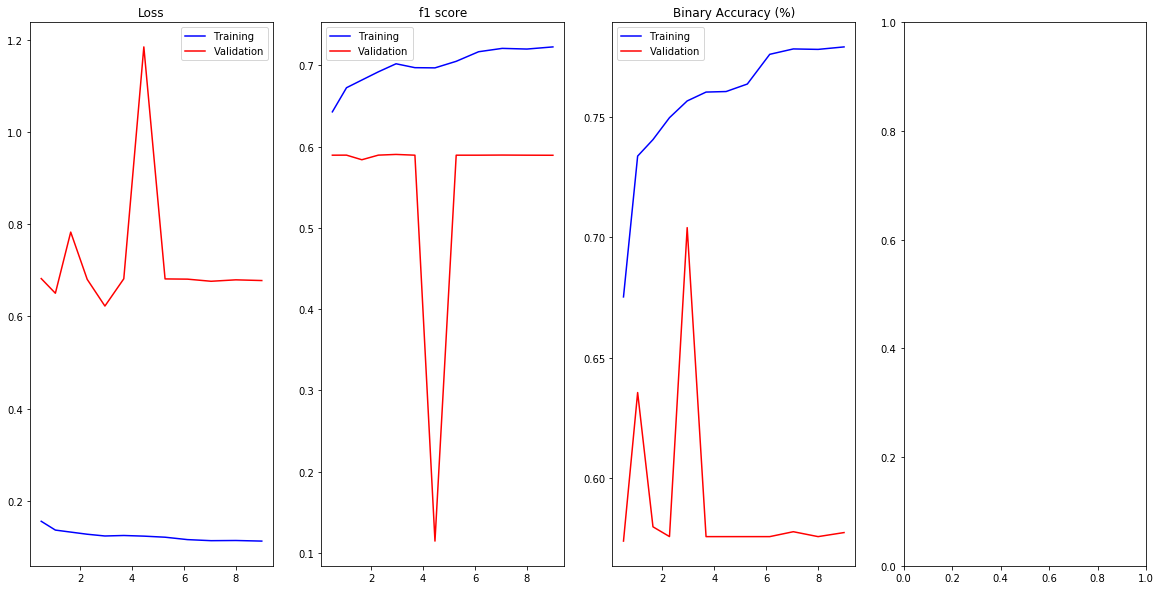

In [35]:
epoch = np.cumsum(np.concatenate([np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
_ = ax1.plot(epoch,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epoch, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 
             'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epoch, np.concatenate([mh.history['f1'] for mh in loss_history]), 
             'b-', epoch, 
             np.concatenate([mh.history['val_f1'] for mh in loss_history]),
             'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('f1 score')

_ = ax3.plot(epoch, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]),
             'b-', epoch, 
             np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]),
             'r-')
ax3.legend(['Training', 'Validation'])
ax3.set_title('Binary Accuracy (%)')
    
#_ = ax4.plot(epoch, np.concatenate([mh.history['lr'] for mh in loss_history]), 
#             'b-')
#ax4.set_title('Learning Rate')



In [84]:
%%time
test_image_preprocessor = ImagePreprocessor(model_parameters, use_aug=False, is_training=False)
predict_generator = PredictGenerator(partition['validation'], test_image_preprocessor, train_image_path)

if isMultiGPU:
    proba_predictions = predict_generator.predict(parallel_model)
else:
    proba_predictions = predict_generator.predict(model)
    
baseline_proba_predictions = pd.DataFrame(proba_predictions, 
                                          columns = train_data.drop(drop_list, axis=1).columns)


100%|██████████| 11044/11044 [07:05<00:00, 27.11it/s]

CPU times: user 10min 41s, sys: 9min 53s, total: 20min 35s
Wall time: 7min 5s


Text(0,0.5,'Percentage')

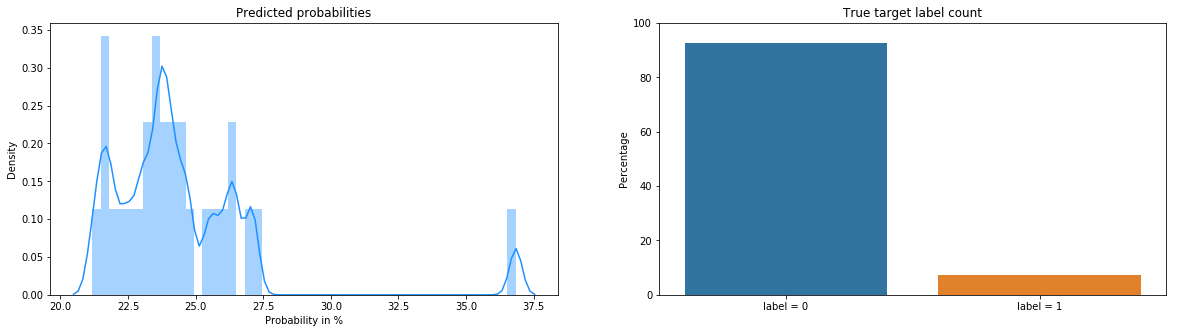

In [85]:
validation_labels = train_data.loc[train_data.Id.isin(partition["validation"])]

hot_values = validation_labels.drop(drop_list, axis=1).values.flatten()
one_hot = (hot_values.sum()) / hot_values.shape[0] * 100
zero_hot = (hot_values.shape[0] - hot_values.sum()) / hot_values.shape[0] * 100

fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(proba_predictions.flatten() * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in %")
ax[0].set_ylabel("Density")
ax[0].set_title("Predicted probabilities")
sns.barplot(x=["label = 0", "label = 1"], y=[zero_hot, one_hot], ax=ax[1])
ax[1].set_ylim([0,100])
ax[1].set_title("True target label count")
ax[1].set_ylabel("Percentage")

Text(0.5,1,'Percentage of hot counts (ones) per target class')

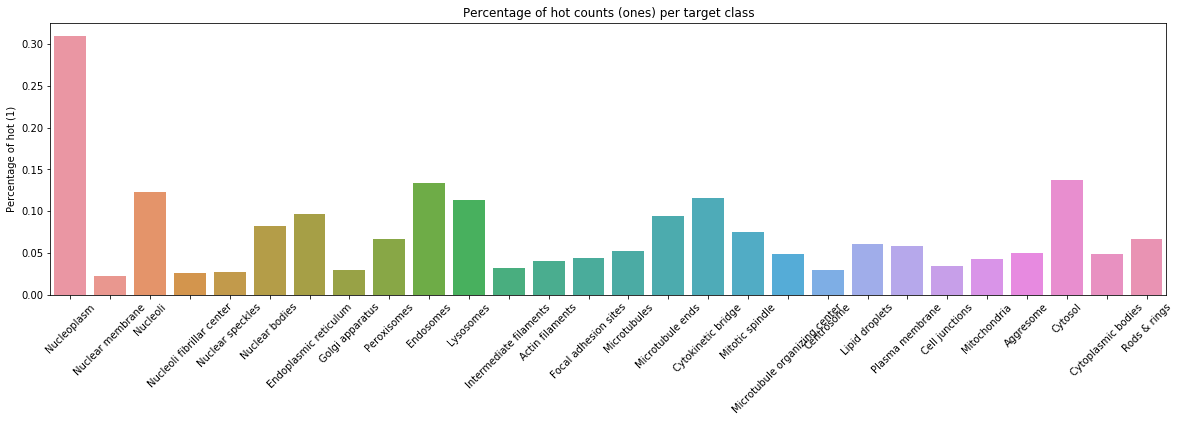

In [86]:
# validation data 中每個 class 的在 overall 中的比例
mean_targets = validation_labels.drop(drop_list, axis=1).mean()
labels = validation_labels.drop(drop_list, axis=1).columns.values
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.barplot(x=labels, y=mean_targets.values, ax=ax)
ax.set_xticklabels(labels=labels, rotation=45)
ax.set_ylabel("Percentage of hot (1)")
ax.set_title("Percentage of hot counts (ones) per target class")

Text(0.5,1,'Standard deviation of predicted probability per class over all samples')

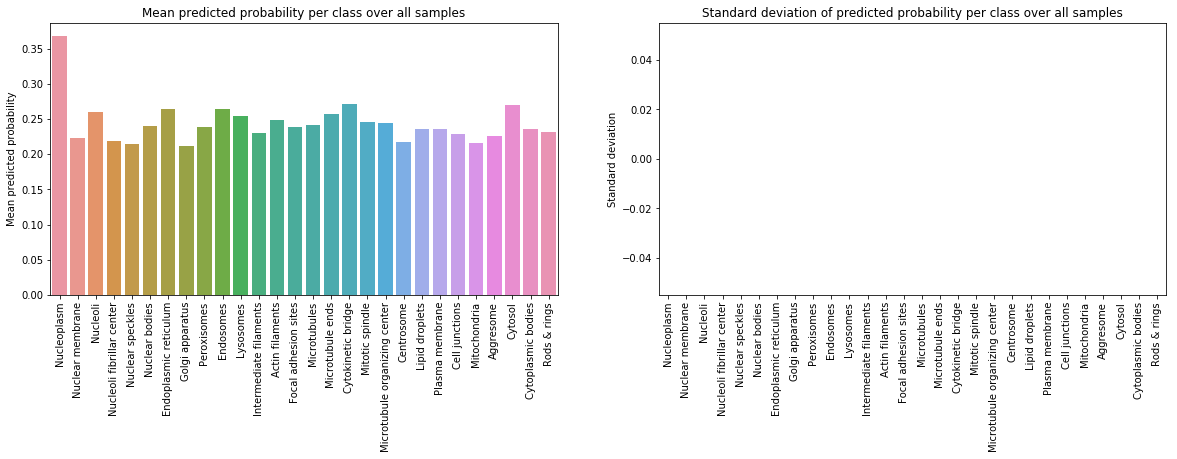

In [87]:
mean_predictions = np.mean(proba_predictions, axis=0)
std_predictions = np.std(proba_predictions, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(x=labels, y=mean_predictions, ax=ax[0])
ax[0].set_xticklabels(labels=labels, rotation=90)
ax[0].set_ylabel("Mean predicted probability")
ax[0].set_title("Mean predicted probability per class over all samples")

sns.barplot(x=labels, y=std_predictions, ax=ax[1])
ax[1].set_xticklabels(labels=labels, rotation=90)
ax[1].set_ylabel("Standard deviation")
ax[1].set_title("Standard deviation of predicted probability per class over all samples")

* Our baseline model seemed to learn something even if this something does not look very nice.
* Taking a look at the standard deviation we can see that all samples have nearly the same predicted values. There is no deviation, no difference between them. This is of course very bad! :-(

(0, 1)

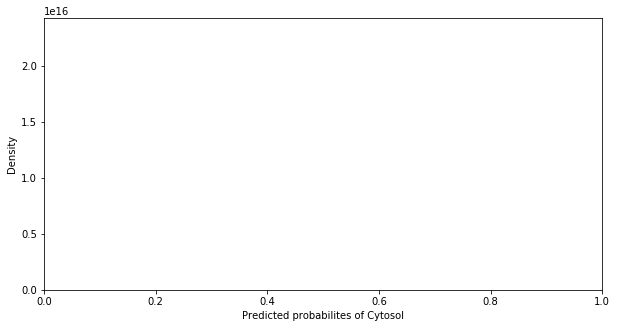

In [88]:
feature = 'Cytosol'
plt.figure(figsize=(10,5))
sns.distplot(baseline_proba_predictions[feature].values[0:-1], color="Purple")
plt.xlabel("Predicted probabilites of {}".format(feature))
plt.ylabel("Density")
plt.xlim([0,1])

# Prediction 

In [ ]:
#seg_model.load_weights(weight_path)
#seg_model.save('seg_model.h5')

In [36]:
isMultiGPU = 0
if isMultiGPU:
    parallel_model = multi_gpu_model(model, 2)
    parallel_model.compile(optimizer=optimizers.Adam(1e-4, decay=1e-6), 
                           loss='binary_crossentropy',
                           metrics=[f1, f1_loss, 'binary_accuracy'])
    parallel_model.load_weights(weight_path)
else:
    model.compile(optimizer=optimizers.Adam(1e-4, decay=1e-6), 
                  loss='binary_crossentropy',
                  metrics=[f1, f1_loss, 'binary_accuracy'])
    model.load_weights(weight_path)


In [37]:
sample_submission = pd.read_csv(str(data_folder / 'sample_submission.csv'))

In [38]:
%%time
test_image_preprocessor = ImagePreprocessor(model_parameters, use_aug=False, is_training=False)
predict_generator = PredictGenerator(sample_submission.Id.values, test_image_preprocessor, test_image_path)

if isMultiGPU:
    proba_predictions = predict_generator.predict(parallel_model)
else:
    proba_predictions = predict_generator.predict(model)

100%|██████████| 11702/11702 [07:22<00:00, 26.66it/s]

CPU times: user 11min 6s, sys: 10min 18s, total: 21min 24s
Wall time: 7min 22s


In [39]:
from datetime import datetime
threshold_list = [0.2]
for threshold in threshold_list:
    submission_df = np.where(proba_predictions > threshold, 1, 0)
    final_submission = []
    for s in range(len(sample_submission.Id.values)):
        predict_labels = ''
        for i in list(np.where(submission_df[s] == 1)[0]):
            predict_labels += str(i) + ' '
        final_submission.append(predict_labels.strip())
    sample_submission['Predicted'] = final_submission
    sample_submission.to_csv('{}_{}_{}.csv'.format(model_arch, 
                                                   str(threshold).replace('.', ''), 
                                                   datetime.now().strftime('%H%M%S')), index=False)
    